# Packet capture analysis


The following presentation discusses and demonstrates the equations and calculations found at https://sflow.org/packetSamplingBasics/index.htm

The data was generated from a packet capture of incoming traffic to my laptop.

```bash
tcpdump -nn -i eno2 dst 192.168.1.248 -w cap.pcap -s 65535
```

### Know your data!!!

During my first run at this analysis, I noticed an anomaly while trying to calculate confidence intervals.  I finally gave up an plotted a histogram of packet lengths.  There were packets of up to 20kb in the long tail!  The distribution was horribly right-skewed.  What happened?  TCP-offload.  I turned off all offload options on the second run.  **Confidence intervals assume a bell-shaped curve that behaves like the Normal Distribution.**  More on this at the end.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

df = pd.read_csv("pcap.csv")
df

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,18.211.118.21,192.168.1.248,TCP,66,443 > 33100 [ACK] Seq=1 Ack=1 Win=17 Len=0 T...
1,2,0.000465,18.211.118.21,192.168.1.248,TLSv1.2,122,Application Data
2,3,0.433247,149.112.112.112,192.168.1.248,TCP,66,443 > 52906 [ACK] Seq=1 Ack=1 Win=588 Len=0 ...
3,4,0.579567,149.112.112.112,192.168.1.248,TLSv1.2,313,Application Data
4,5,1.048138,208.85.40.20,192.168.1.248,TCP,66,443 > 42740 [ACK] Seq=1 Ack=1 Win=65535 Len=...
...,...,...,...,...,...,...,...
165363,165364,34874.948849,172.217.7.238,192.168.1.248,TLSv1.3,323,Application Data
165364,165365,34874.948913,172.217.7.238,192.168.1.248,TLSv1.3,125,Application Data
165365,165366,34874.948920,172.217.7.238,192.168.1.248,TLSv1.3,105,Application Data
165366,165367,34875.006143,172.217.7.238,192.168.1.248,TCP,66,443 > 60028 [ACK] Seq=125153 Ack=290153 Win=...


## Discussion of sample size

The article uses an example of 1M packets as the population size and some other random figures for classes of packets within that population.  The sample size is solely dependent on the error function.

### Minimum sample size needed for an interval estimate of a population proportion

$$n = \hat{p}\hat{q}\bigg(\frac{z_{\alpha / 2}}{E}\bigg)^2$$

Where `n` is the sample size, $z_{\alpha / 2}$ is the critical value of the normal distribution, and `E` is the margin of error desired.  When $\hat{p}$ and $\hat{q}$ are unknown, it is advised to use $0.5^2$.

There are 165,368 packets in my capture.  We will assume a critical value ($z_{\alpha /2}$) of 1.96 (95% confidence) which corresponds to the numbers used in the paper cited above.

In [4]:
n = int(
  round(0.25 * (1.96 / 0.05)**2, 0)
)
n

384

In [5]:
N = df["No."].max()
X = 1.96**2 * 0.25 / 0.05**2
nn = N*X/(X + N -1)
nn

383.2719534511854

## Equation 1

Estimated number of packets of a given class.  I am using a randomly-picked host IP as my class.

$$N_c = \frac{c}{n}\cdot N$$

In [6]:
# Randomly-picked host
host = "170.199.160.140"

N = df["No."].max()
# random_state to keep results repeatable
samples = df.sample(n=n, replace=True, random_state=1)
c = len(samples[samples["Source"] == host])
N_c = c / n * N
N_c

9474.208333333332

## Equation 2

Calculate the variance of the sample.  Standard deviation is simply the square root of the variance.

$$\sigma^2 = N^2 \cdot \frac{c \cdot \bigg (1-\frac{c}{n}\bigg )}{n^2-n}$$

In [7]:
sig_sq = (N**2) * (c* (1 - c / n))/(n**2 - n)
sig = sqrt(sig_sq)
print(f"Variance: {round(sig_sq, 2)}")
print(f"Standard deviation: {round(sig, 2)}")


Variance: 3856319.22
Standard deviation: 1963.75


## Equation 3

The 95% confidence interval for $N_c$.

In [8]:
[N_c - 1.96 * sig, N_c + 1.96 * sig]

[5625.255760989759, 13323.160905676905]

The nubers above may appear to be quite large, but keep in mind what we are really interested in is sample proportions.  That 95% confidence interval translates to a sample proportion given by the following cell.

In [9]:
population_prop = len(df[df.Source == host]) / df["No."].max()

print(f"[{round((N_c - 1.96 * sig)/N, 2)}, {round((N_c + 1.96 * sig)/N, 2)}]")
print(f"Actual population proportion: {round(population_prop, 2)}")

[0.03, 0.08]
Actual population proportion: 0.05


## Does it work?

The confidence interval changes slightly with each new random sample.  It should be fairly rare that the true population proportion is outside of this interval.

In [10]:
from random import randint
def run_prop_trials():
  for i in range(10):
    misses = 0
    trials = 100
    for i in range(trials):
      # No seed this time
      samples = df.sample(n=n, replace=True)
      c = len(samples[samples["Source"] == host])
      N_c = c / n * N
      low = (N_c - 1.96 * sig)/N
      high = (N_c + 1.96 * sig)/N
      if low <= population_prop <= high:
        continue
      # print(f"Miss!  {low} <= {population_prop} <= {high}")
      misses += 1
    print(f"{misses} misses in {trials} trials")
run_prop_trials()

4 misses in 100 trials
5 misses in 100 trials
4 misses in 100 trials
4 misses in 100 trials
4 misses in 100 trials
1 misses in 100 trials
6 misses in 100 trials
1 misses in 100 trials
12 misses in 100 trials
4 misses in 100 trials


Equation 5 - 17 dive into the previous numbers in more detail.

## Equations 18 - 22

Packet is very interested in byte counts for billing purposes.

$$B_c = sum(sample\_bytes)$$
$$var(B_c) = var(N_c) \cdot var(\bar{b_c})+N^2_c\cdot var(\bar{b_c})+\bar{b_c}^2 \cdot var(N_c)$$

In [11]:
tot_bytes = df["Length"].sum()
samples = df.sample(n=n, replace=True, random_state=1)
pop_bytes_prop = df[df["Source"] == host]["Length"].sum() / tot_bytes

matches = samples[samples["Source"] == host]
c = len(matches)
N_c = c / n * N
b_c_ = matches.agg({"Length": ["mean"]})["Length"]["mean"]
B_c = b_c_ * N_c
print(f"Estimated sum of class bytes (B_c): {int(round(B_c, 0))}")
var_b_c_ = (((matches["Length"] - b_c_)**2).sum() - B_c/c)/(c - 1)
var_B_c = sig_sq * var_b_c_ + N_c**2 * var_b_c_ + b_c_**2 * sig_sq
print(f"Variance B_c: {round(var_B_c, 2)}")

sig_B_c = sqrt(var_B_c)
print(f"Standard deviation of B_c: {round(sig_B_c, 2)}")
print(f"Confidence interval: [{int(round(B_c - 1.96 * sig_B_c, 0))}, {int(round(B_c + 1.96 * sig_B_c, 0))}]")

Estimated sum of class bytes (B_c): 14343951
Variance B_c: 5932866153414.02
Standard deviation of B_c: 2435747.56
Confidence interval: [9569886, 19118017]


In [12]:
pop_bytes_prop = df[df["Source"] == host]["Length"].sum() / tot_bytes
def run_byte_trials():
  for i in range(10):
    misses = 0
    trials = 100
    for i in range(trials):
      # No seed this time
      samples = df.sample(n=n, replace=True)
      matches = samples[samples["Source"] == host]
      c = len(matches)
      N_c = c / n * N
      b_c_ = matches.agg({"Length": ["mean"]})["Length"]["mean"]
      B_c = b_c_ * N_c
      var_b_c_ = (((matches["Length"] - b_c_)**2).sum() - B_c/c)/(c - 1)
      var_B_c = sig_sq * var_b_c_ + N_c**2 * var_b_c_ + b_c_**2 * sig_sq
      sig_B_c = sqrt(var_B_c)
      low = (B_c - 1.96 * sig_B_c) / tot_bytes
      high = (B_c + 1.96 * sig_B_c) / tot_bytes
      if low <= pop_bytes_prop <= high:
        continue
      # print(f"{round(pop_bytes_prop, 3)} not in the interval [{round(low, 3)}, {round(high, 3)}]")
      misses += 1
    print(f"{misses} misses in {trials} trials")
run_byte_trials()

8 misses in 100 trials
7 misses in 100 trials
9 misses in 100 trials
6 misses in 100 trials
7 misses in 100 trials
5 misses in 100 trials
6 misses in 100 trials
4 misses in 100 trials
7 misses in 100 trials
12 misses in 100 trials


## Not too bad!

... but a little higher than we expected when using a 95% confidence interval.  For an explanation of this, we need to look at the data.



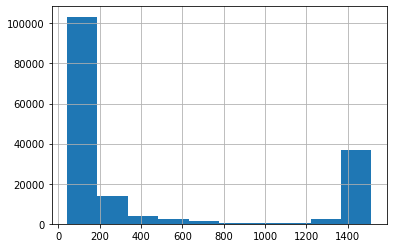

In [13]:
_ = df["Length"].hist()

As you can see, this particular sample is bimodal and nowhere near a Normal Distribution.  The population I am using in this example is tiny compared to the data traversing a production network.  The number of samples will be much higher as well.

## Key takeaways

- Check your data, don't make assumptions
- The error function only depends on the *number of samples taken*, but the confidence interval **is** dependent on the number of samples taken as well as the sample size.  There is an inverse relationship between variance and the proportion of sample size to population.
- Smaller customers will perceive greater billing inaccuracy than larger customers (size relative to traffic generated).
- Track the critical metrics.  Timestamps, byte counters, and sample data must be accurate to perform correct calculations.